# Demanda de Energía en Tenerife - PARTE 1

### Estudio de series temporales y forecasting

Jose Luis Quintero García, Marzo 2023

Este estudio consiste en la recopilación de datos de demanda energética en Tenerife desde 2013 hasta 2023 y en el tratamiento de la serie de datos resultante para terminar realizando un forecast de deicho consumo.

* Los datos recogidos de la web https://demanda.ree.es/ son de demanda energética en Tenerife para cada 5 minutos. Se aprovechará para estudiar la diferencia de estudiar estos datos con este nivel de agregación o datos con medias para cada hora y analizar el nivel de exactitud del forecast para previsiones de 1 semana.

* Se analizará el dataset tal cual ha sido recogido de la web y, por otro lado, se estudiará con la adición de datos exógenos como festivos o fines de semana, para ver la diferencia en el forecast a 1 semana.

* En una primera parte, se usarán métodos clásicos, como SARIMA, mientras que en una segunda paete, usaremos métodos clásicos de machine learning.

## Importación de librerías y carga del dataset

In [44]:
import pandas as pd
import numpy as np

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima   

from adf_test import adf_test
from sklearn.impute import KNNImputer

pd.set_option('display.max_rows', None)

In [3]:
data5m = pd.read_csv("./demanda_energia_TF_5m.csv", index_col="fecha")
data5m.head()

,consumo
fecha,
2012-12-31 20:00,546.0
2012-12-31 20:05,546.0
2012-12-31 20:10,545.0
2012-12-31 20:15,543.0
2012-12-31 20:20,540.0


## Transformación de los datos

In [4]:
# Contamos los registros duplicados
data5m.index.duplicated().sum()

270527

In [5]:
# Eliminamos los duplicados
data5m = data5m[~data5m.index.duplicated()]
data5m.index.duplicated().sum()

0

In [6]:
data5m.index = pd.to_datetime(data5m.index)
data5m = data5m.asfreq(freq='5T') # Cambiamos la frecuencia a 5 minutos
data5m.index

DatetimeIndex(['2012-12-31 20:00:00', '2012-12-31 20:05:00',
               '2012-12-31 20:10:00', '2012-12-31 20:15:00',
               '2012-12-31 20:20:00', '2012-12-31 20:25:00',
               '2012-12-31 20:30:00', '2012-12-31 20:35:00',
               '2012-12-31 20:40:00', '2012-12-31 20:45:00',
               ...
               '2023-03-03 01:15:00', '2023-03-03 01:20:00',
               '2023-03-03 01:25:00', '2023-03-03 01:30:00',
               '2023-03-03 01:35:00', '2023-03-03 01:40:00',
               '2023-03-03 01:45:00', '2023-03-03 01:50:00',
               '2023-03-03 01:55:00', '2023-03-03 02:00:00'],
              dtype='datetime64[ns]', name='fecha', length=1069417, freq='5T')

Vamos a estudiar si existen valores nulos:

In [28]:
data5m.isnull().sum()

consumo    132
dtype: int64

Efectivamente, existem 132 valores nulos. Vamos a ver cuales son:

In [30]:
data5m.loc[data5m["consumo"].isnull()]

,consumo
fecha,
2013-03-31 01:00:00,NaN
2013-03-31 01:05:00,NaN
2013-03-31 01:10:00,NaN
2013-03-31 01:15:00,NaN
2013-03-31 01:20:00,NaN
2013-03-31 01:25:00,NaN
2013-03-31 01:30:00,NaN
2013-03-31 01:35:00,NaN
2013-03-31 01:40:00,NaN


Si acudimos a la web original, podemos ver que, efectivamente, faltan estos datos. Es decir, no es un error de webscraping o tratamiento posterior.

Esto es un problema, dado que no nos pueden faltar datos en la serie temporal para la utilización de determinados algoritmos, por lo que debemos completar la serie. Para ello, usaremos una imputación que se vale de K-nearest neighbors para tomar el valor no nulo más cercano.

In [32]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputer.fit(data5m[["consumo"]])
data5m["consumo"] = imputer.transform(data5m[["consumo"]]).ravel()
data5m.isnull().sum()

consumo    0
dtype: int64

Ya podemos visualizar los datos

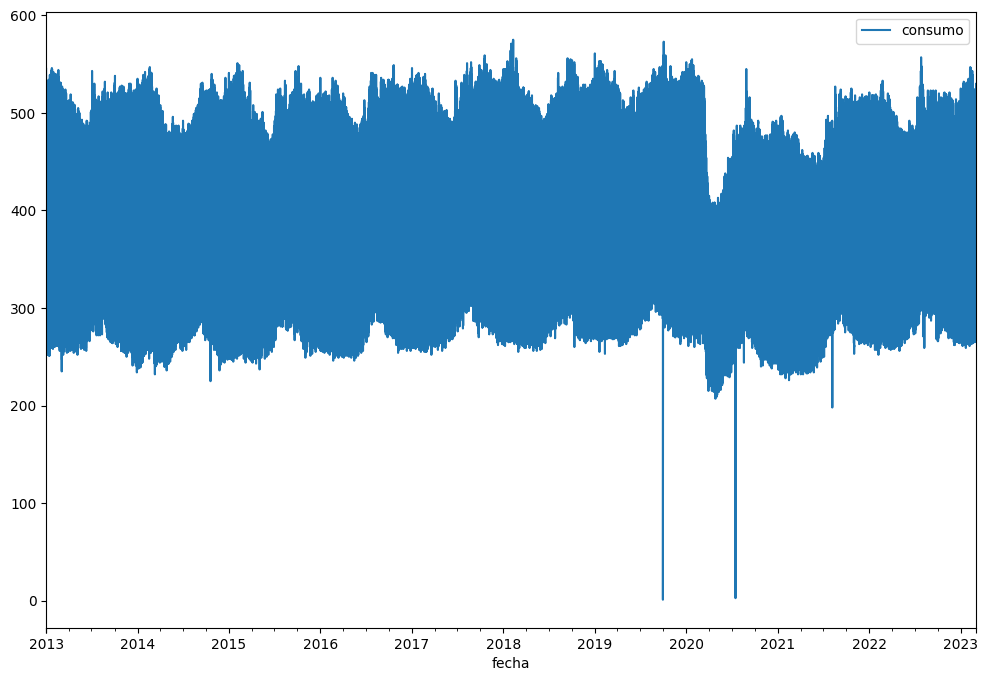

In [33]:
data5m.plot(figsize=(12,8));

## Ceros energéticos y anomalía en 2020

In [80]:
data5m.loc[data5m["consumo"]<=100].index

DatetimeIndex(['2019-09-29 13:25:00', '2019-09-29 13:30:00',
               '2019-09-29 13:35:00', '2019-09-29 13:40:00',
               '2019-09-29 13:45:00', '2019-09-29 13:50:00',
               '2019-09-29 13:55:00', '2019-09-29 14:00:00',
               '2019-09-29 14:05:00', '2019-09-29 14:10:00',
               '2019-09-29 14:15:00', '2019-09-29 14:20:00',
               '2019-09-29 14:35:00', '2019-09-29 14:40:00',
               '2019-09-29 14:45:00', '2019-09-29 14:50:00',
               '2019-09-29 14:55:00', '2019-09-29 15:00:00',
               '2019-09-29 15:05:00', '2019-09-29 15:10:00',
               '2019-09-29 15:15:00', '2019-09-29 15:20:00',
               '2019-09-29 15:25:00', '2019-09-29 15:30:00',
               '2019-09-29 15:35:00', '2019-09-29 15:40:00',
               '2019-09-29 15:45:00', '2019-09-29 15:50:00',
               '2019-09-29 15:55:00', '2019-09-29 16:00:00',
               '2019-09-29 16:05:00', '2019-09-29 16:10:00',
               '2019-09-

Aquí tenemos la bonita oportunidad de ver los famosos dos "ceros energéticos" que hubo en Tenerife el 29/09/2019 y el 15/07/2020.

Vemos que el primero duró desde las 13:25 hasta las 18:00 y el segundo desde las 10:25 hasta las 12:20

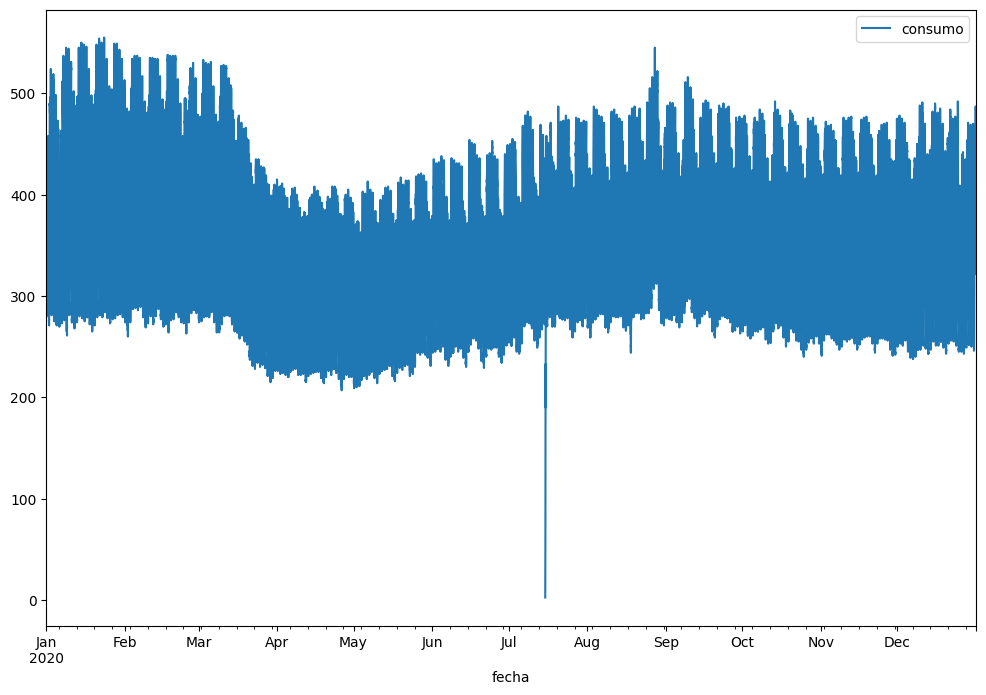

In [81]:
data5m.loc[data5m.index.year==2020].plot(figsize=(12,8));

En el año 2020, además del "cero" en julio, vemos una anomalía en el consumo desde el mes de marzo, con una pronunciada caída durante varios meses. En el año anterior, por ejemplo, no se produce este patrón:

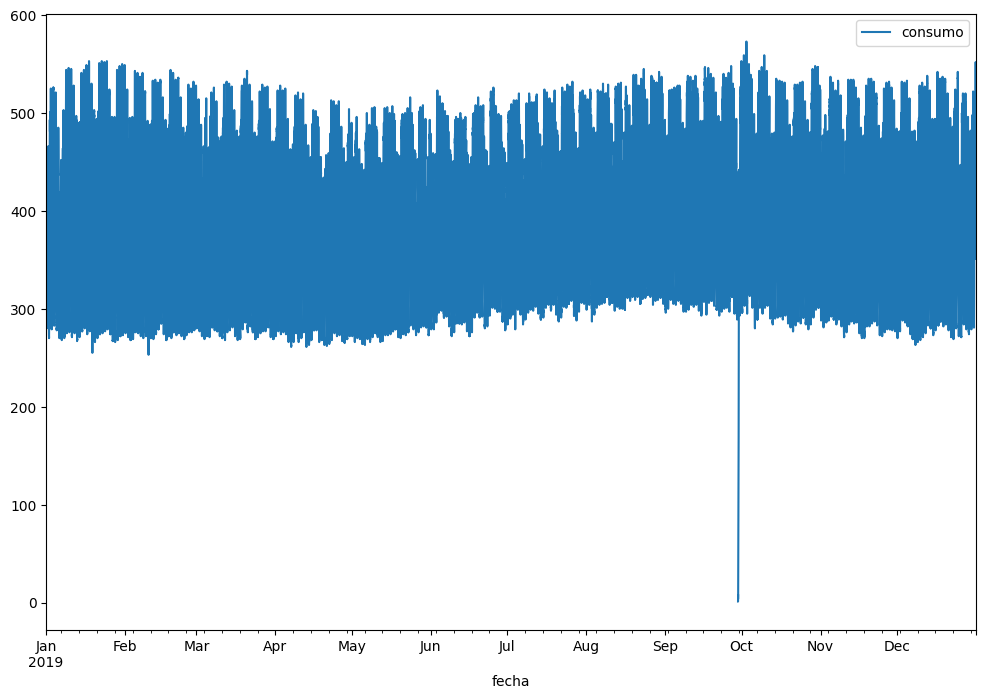

In [82]:
data5m.loc[data5m.index.year==2019].plot(figsize=(12,8));

Aquí, excepto el "cero" de septiembre, hay una serie mucho más regular que en 2021, muy parecida a la de otros años.

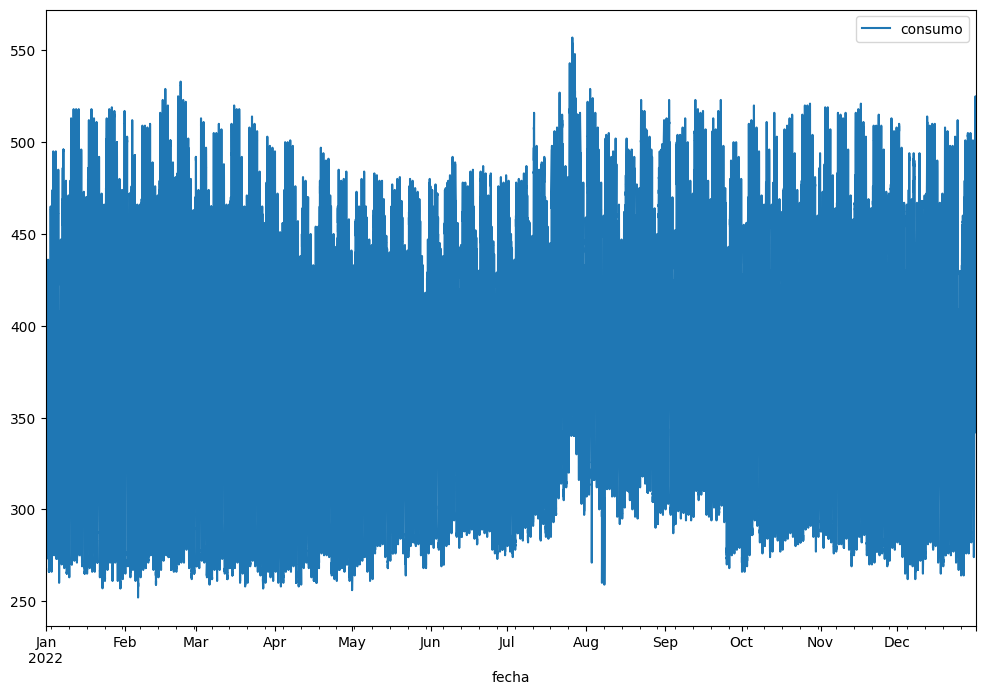

In [83]:
data5m.loc[data5m.index.year==2022].plot(figsize=(12,8));

¿Qué pasó en 2020 para explicar esa caída en el consumo frente a lo ocurrido en otros años? Por supuesto, el COVID-19. Las medidas de confinamiento decretadas en marzo de 2020 supusieron un notable descenso del consumo eléctrico, que fué recuperándose lenta y parcialmente en meses posteriores conforme se iba recuperando la actividad.

Ejecutamos un test de Dickey-Fuller, que nos indicará si la serie temporal es o no estacionaria. Usamos una función que automatiza el proceso e interpreta el p-value resultante. Dado que el dataset es bastante grande, usamos solo los datos de 2021 para el test.

In [6]:
adf_test(data5m["consumo"].loc[data5m.index.year==2021])

Augmented Dickey-Fuller Test
ADF test                   -34.241158
p-value                      0.000000
# lags                      69.000000
# observaciones         105038.000000
critical value (1%)         -3.430412
critical value (5%)         -2.861568
critical value (10%)        -2.566785
Rechazamos la hipótesis nula
La serie es estacionaria


Si la serie es estacionaria, usaremos el modelo ARMA para tratar con ella. Vamos a estudiar la estacionalidad de la serie.

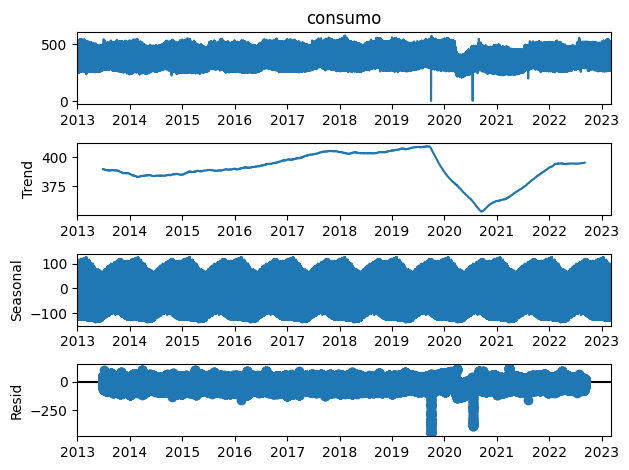

In [43]:
# La frecuencia de 5' de nuestros datos dan problemas a la hora de ejecutar seasonal_decompose 
# de statsmodel. Ver corrección en:
# https://stackoverflow.com/questions/36083832/valueerror-freq-t-not-understood-please-report-if-you-think-this-in-error-se

decompfreq = ((60*24*30*12)//5) # 60 min x 24h x 30dias x 12 meses // 5 minutos
decomposition = seasonal_decompose(data5m["consumo"],period=decompfreq, model="add")
decomposition.plot();

Este gráfico es bastante descriptivo:

- Vemos que desde 2014 a 2020 hay una leve tendencia ascendente en el consumo, que cae abruptamente en 2020 (a causa del covid). Y que a 2022, aún no se ha recuperado la tendencia.
- Podemos observar una clara estacionalidad anual.